# Introducción

___



En la primer clase repasamos algunos conceptos clásicos sobre el aprendizaje automático. Se repasaron ahí las aproximaciones de aprendizaje supervisado, no supervisado y por refuerzo.  

Los objetivos de este _notebook_ son:
1. Cimentar algunos conceptos básicos que seguiremos viendo a lo largo del curso cuando pasemos a modelos de aprendizaje profundo (_e.g._ procesamiento de datos, funciones de pérdida, _overfitting_).
2. Ver estos conceptos en acción en un caso de aprendizaje supervisado y uno no supervisado.
3. Familiarizarnos con rudimentos de PyTorch, una librería que utilizaremos de ahora en más.

Para ello vamos a analizar un _dataset_ muy popular, llamado comunmente "_penguins dataset_". Utilizaremos estos datos para predecir el valor de una variable en función de otra (i.e., una regresión lineal) y realizar una clasificación de cada individuo en base a sus características (_i.e._, _clustering_ de los datos).


> **Nota**: Este _notebook_ está inspirado en trabajo realizado por el Dr. Ignacio Ramírez para el curso "_Aprendizaje automático básico para científicos (AABC)_", el cual compartió amablemente materiales. Dicho curso también se encuentra organizado por CICADA.


___

**TO-DO**: 
    - incorporar temas del overfitting, bias-variance, etc
    - Meterle lo del overfitting capaz con el problema de los picos. Ver si no se puede aprender una función mas compleja que tome en cuenta las dos medidas para sacar el peso, por ejemplo (tiene sentido esto? habra informacion redundante? pensando en voz alta...)
___

# _"Penguins dataset"_, nuestro objeto de estudio

*Tiempo estimado: ~x horas*

___


<div>
<center>
<img src="https://imgur.com/orZWHly.png" width="60%"/>
</center>
</div>

El [Penguins Dataset](https://github.com/allisonhorst/palmerpenguins) se trata de un _dataset_ donde se listan 5 caracteristicas para tres especies distintas de pingüinos. Los datos son: el sexo del pingüino, largo y ancho del pico ("_bill_" en ingles), el largo de la aleta ("_flipper_") y el peso en gramos de cada individuo.

<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/man/figures/culmen_depth.png" width="500" />
</div>

En el mismo hay tres especies distribuidas en distintas islas del Archipielago de Palmer.

Como primera tarea vamos a observar nuestros datos, en lo que típicamente se llama un "análisis exploratorio".

## Análisis exploratorio del _dataset_

El primer paso es, naturalmente, importar los datos. Afortunadamente, la librería _seaborn_ posee al _dataset_ entre los datos disponibles

In [204]:
# cargamos las librerias
import seaborn as sns,  pandas as pd
import matplotlib.pyplot as plt
pd.set_option("compute.use_numexpr", False)

# importamos el dataset
penguins = sns.load_dataset('penguins')

data = pd.DataFrame(penguins)

In [205]:
# pispeamos los datos
data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


Vemos que cada fila corresponde a un individuo. En las columnas se encuentran las variables que ya habíamos mencionado

In [206]:
# con el metodo .info() podemos ver un poco más, incluyendo datos faltantes por variable
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [207]:
# con shape podemos ver las dimensiones del dataset 
print(data.shape) # cuantos individuos hay?

(344, 7)


In [208]:
# con el metodo .describe() podemos obtener algunos datos mas cuantitativos de cada variable
data.describe(include='all')

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000000,342.000000,342.000000,342.000000,333
unique,3,3,NaN,NaN,NaN,NaN,2
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,Male
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN
std,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN


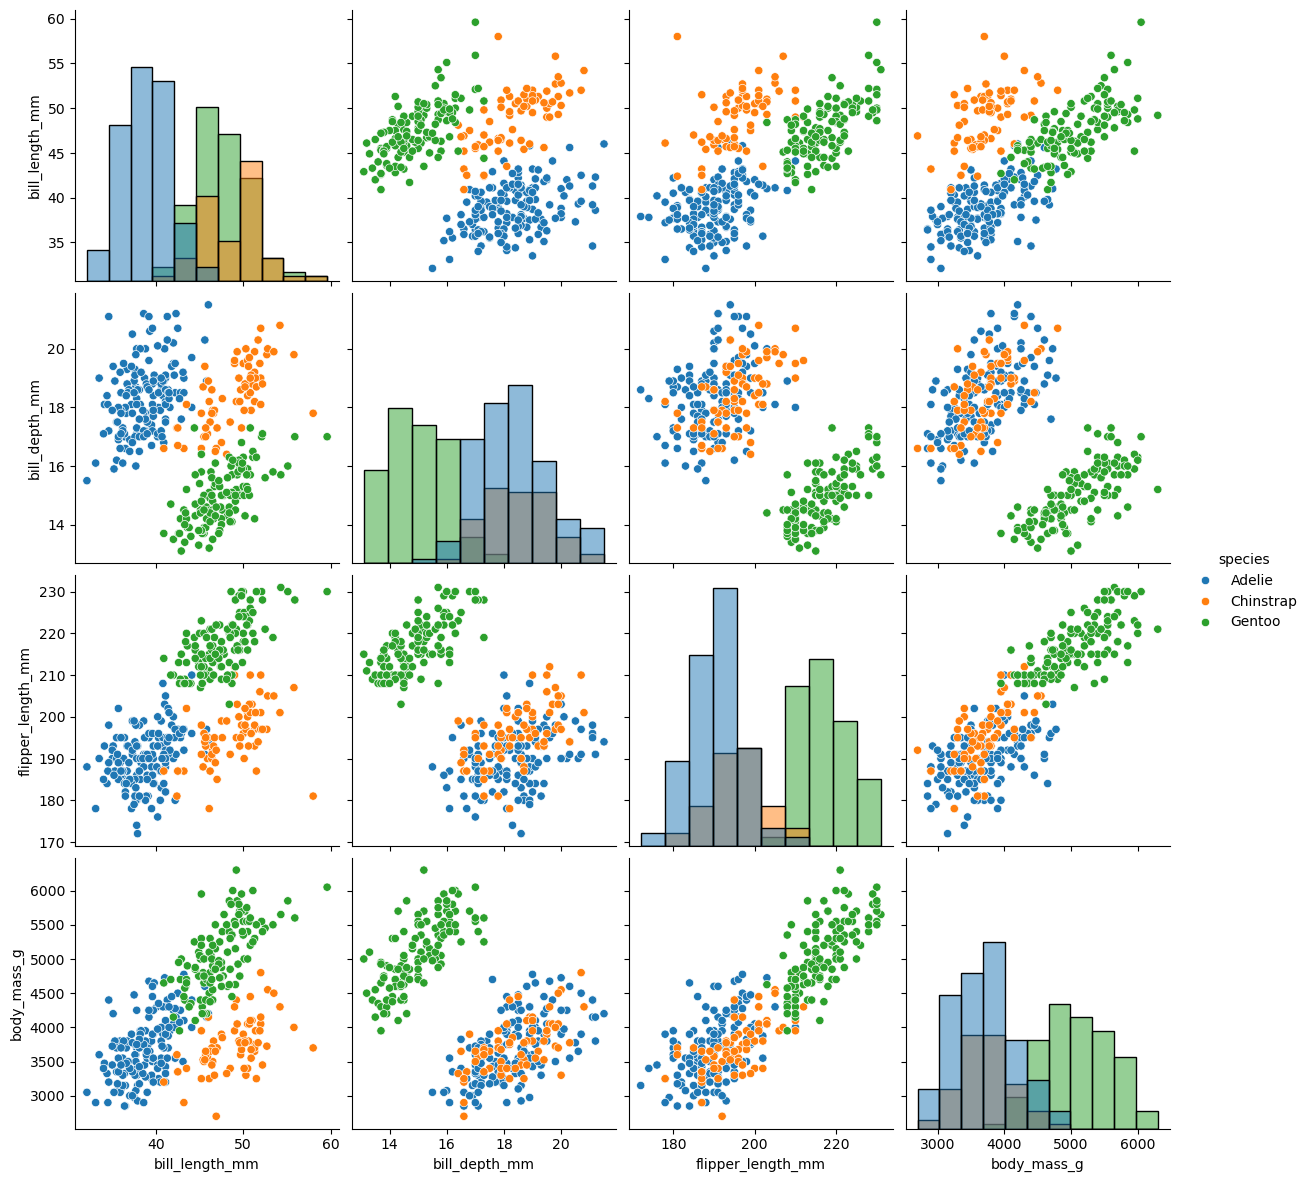

In [209]:
sns.pairplot(data, hue="species", height=3,diag_kind="hist")

Vemos, por ejemplo, que las diferentes especies de pingüino tienen diferente relación para las variables `bill_depth_depth` y `bill_length_mm`

<Axes: xlabel='bill_length_mm', ylabel='bill_depth_mm'>

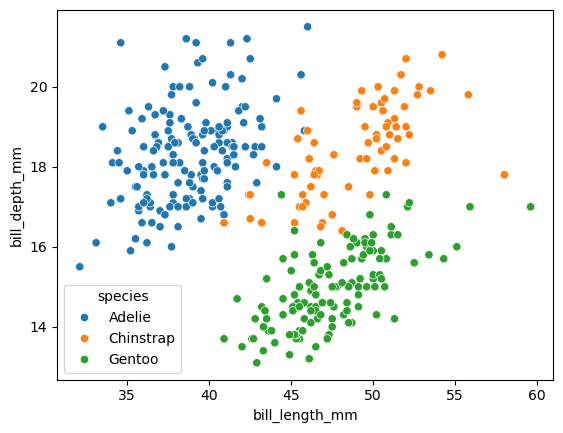

In [210]:
sns.scatterplot(data = data, hue = 'species', x = 'bill_length_mm', y = 'bill_depth_mm')

Teniendo en cuenta esto, una pregunta natural sería: ¿podríamos predecir la especie de pingüino en base a estas dos medidas del pico de una forma eficiente?

# Aprendizaje no supervisado

Para abordar este problema vamos primero a tomar un enfoque de **aprendizaje no supervisado**. Bajo este enfoque no vamos a codificar explícitamente en nuestro algoritmo de aprendizaje a qué especie pertenece cada pingüino. El princpio que opera es el siguiente: si la relación entre las variables que usamos para entrenar correlaciona bien con la especie del individuo, un algoritmo de aprendizaje eficaz debería ser capaz de detectar grupos de individuos con características similares; estos grupos deberían correlacionar con las especies de los individuos.

Para ilustrar este concepto, vemos a continuación cómo funciona el algoritmo que vamos a emplear: ***k-means clustering***. 

![Explicación visual del algoritmo kNN. Tomado de www.tidymodels.org](https://raw.githubusercontent.com/mauriciolangleib/capibara_cicada_2025/refs/heads/main/imgs/kNN_explicado.gif)

> **Nota**: Para más información sobre el algoritmo de _k-means clustering_, se pueden ver recursos como https://scikit-learn.org/stable/modules/clustering.html#k-means.

Muy bien, ahora tenemos varias cuestiones a abordar:

1. ¿**Cómo vamos a implementar** el algoritmo?
2. ¿Qué **parámetros** vamos a emplear? Pensemos que tenemos parámetros como el _número de centroides ($k$)_ o la _distancia a emplear_.
3. ¿Cómo vamos a **medir** el éxito de nuestra aproximación?

Resolvamos estas preguntas una a una.

Para llevar a cabo la clasificación en base al algoritmo de _k-means clustering_ podríamos escribir código que haga esto sin un esfuerzo muy grande (ver, por ejemplo, https://www.kaggle.com/code/fareselmenshawii/kmeans-from-scratch). **En este práctico optamos por no tomar esta aproximación, en tanto no es un curso de _machine learning_ desde cero**; estamos utilizando este ejercicio para refrescar conceptos que se supone viste alguna vez. No obstante, si sentís que la idea de implementar esto de cero sería algo imposible, puede ser interesante que veas el código del ejemplo (u otras implementaciones), solo para desmitificar esto.

In [13]:
from sklearn.cluster import KMeans # traemos k-means clustering de sk-learn

Pronto, con esta simple línea de código vamos a poder utilizar el algoritmo sobre nuestros datos sin problemas!

Respecto a los parámetros a emplear

In [53]:
data_k = data.query("not body_mass_g.isnull() and not flipper_length_mm.isnull()", engine = 'python')

In [54]:
from sklearn.model_selection import train_test_split # separación de datos en entrenamiento, testeo y validación
X = data_k[['bill_depth_mm','bill_length_mm']].to_numpy()
y = data_k.species.to_numpy()

In [55]:
kmeans= KMeans(n_clusters = 3, random_state = 42)

# Compute k-means clustering
kmeans.fit(X)

# Compute cluster centers and predict cluster index for each sample.
pred = kmeans.predict(X)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,

In [56]:
import matplotlib.pyplot as plt

In [58]:
data_k = data_k.assign(species_pred = pred)

In [59]:
data_k

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,species_pred
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,2
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,2
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,2
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,2
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,2
...,...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female,0
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female,0
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male,1
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female,0


In [60]:
data_k = data_k.query("not body_mass_g.isnull() and not flipper_length_mm.isnull()", engine = 'python')

/var/folders/zc/ty1kvmv55fs1z8sx922rqzsw0000gn/T/ipykernel_84251/930565014.py:43: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



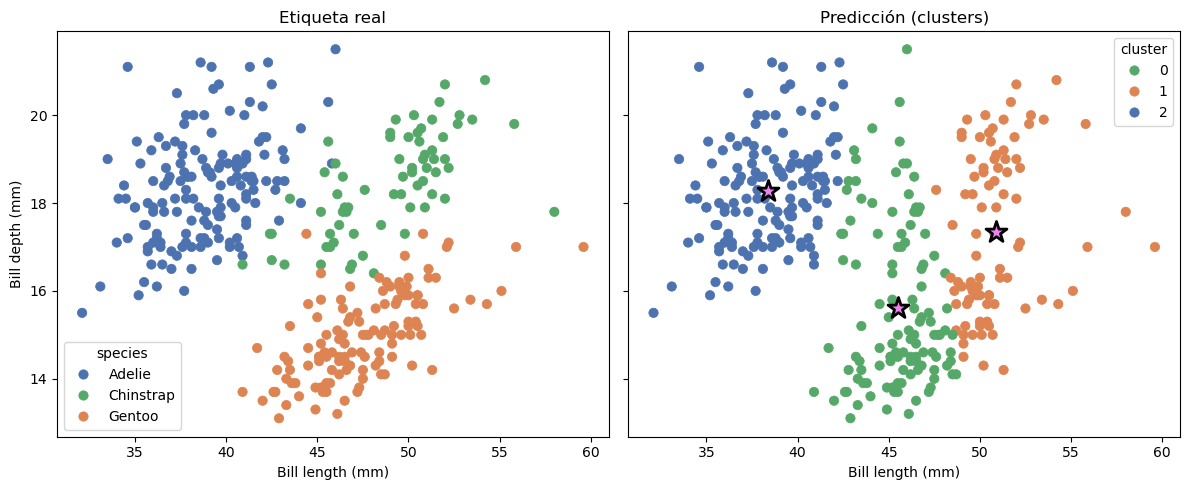

In [61]:
# ----- Paleta: seaborn deep en orden azul, verde, naranja -----
deep = sns.color_palette("deep")
COLORS = [deep[0], deep[2], deep[1]]  # azul, verde, naranja

# Hardcode de colores por cluster (ajustá las claves si tus labels no son 0/1/2)
CLUSTER_COLORS = {0: COLORS[1], 
                  1: COLORS[2], 
                  2: COLORS[0]}

# Colores para etiquetas reales (mismo set, en el mismo orden determinista)
species_order = sorted(data_k['species'].astype(str).unique())
SPECIES_COLORS = {sp: COLORS[i % len(COLORS)] for i, sp in enumerate(species_order)}

# Asegurar hue categórico para evitar el problema de “2 colores”
data_k['cluster'] = pd.Categorical(data_k['species_pred'], categories=list(CLUSTER_COLORS.keys()))

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Panel A: etiqueta real
sns.scatterplot(
    data=data_k, x='bill_length_mm', y='bill_depth_mm',
    hue='species', hue_order=species_order, palette=SPECIES_COLORS,
    s=45, edgecolor=None, ax=axes[0]
)
axes[0].set_title('Etiqueta real')
axes[0].set_xlabel('Bill length (mm)')
axes[0].set_ylabel('Bill depth (mm)')
axes[0].legend(title='species')

# Panel B: predicción (clusters)
cluster_order = list(CLUSTER_COLORS.keys())
sns.scatterplot(
    data=data_k, x='bill_length_mm', y='bill_depth_mm',
    hue='cluster', hue_order=cluster_order, palette=CLUSTER_COLORS,
    s=45, edgecolor=None, ax=axes[1]
)
axes[1].set_title('Predicción (clusters)')
axes[1].set_xlabel('Bill length (mm)')
axes[1].set_ylabel('')

# Centroides (media por cluster en las dos variables ploteadas)
cent = (data_k
        .groupby('cluster')[['bill_length_mm', 'bill_depth_mm']]
        .mean()
        .reindex(cluster_order))

axes[1].scatter(
    cent['bill_length_mm'], cent['bill_depth_mm'],
    marker='*', s=250, linewidths=2, edgecolors='black',  
    c='violet', label='Centroides'
)

plt.tight_layout()
plt.show()

A golpe de vista podemos ver que existen errores en clasificar las especies `Chinstrap` y `Gentoo`. Veamos qué tan acertados fuimos en la clasificación viendo el porcentaje de clasificados correctamente

In [65]:
cluster2species = {2:'Adelie', 1: 'Gentoo', 0: 'Chinstrap'}

In [67]:
data_k = data_k.assign(species_pred = lambda df: [cluster2species.get(x) for x in df.cluster])

In [75]:
print(f'Porcentaje de clasificaciones correctas: {data_k.query("species == species_pred").shape[0]/data_k.shape[0]*100} %')

Porcentaje de clasificaciones correctas: 61.69590643274854 %


Pero si miramos bien en nuestro analisis exploratorio, `flipper_length_mm` separa bien a la especie Chinstrap del resto cuando se toma en cuenta con `bill_depth_mm`. Probemos hacer el analisis, esta vez con tres variables (sumamos a `flipper_length_mm`).

In [77]:
data_k = data_k.query("not flipper_length_mm.isnull()") # nos sacamos los casos que no tengan esta medida

In [78]:
SPECIES_COLORS

{'Adelie': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 'Chinstrap': (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 'Gentoo': (0.8666666666666667, 0.5176470588235295, 0.3215686274509804)}

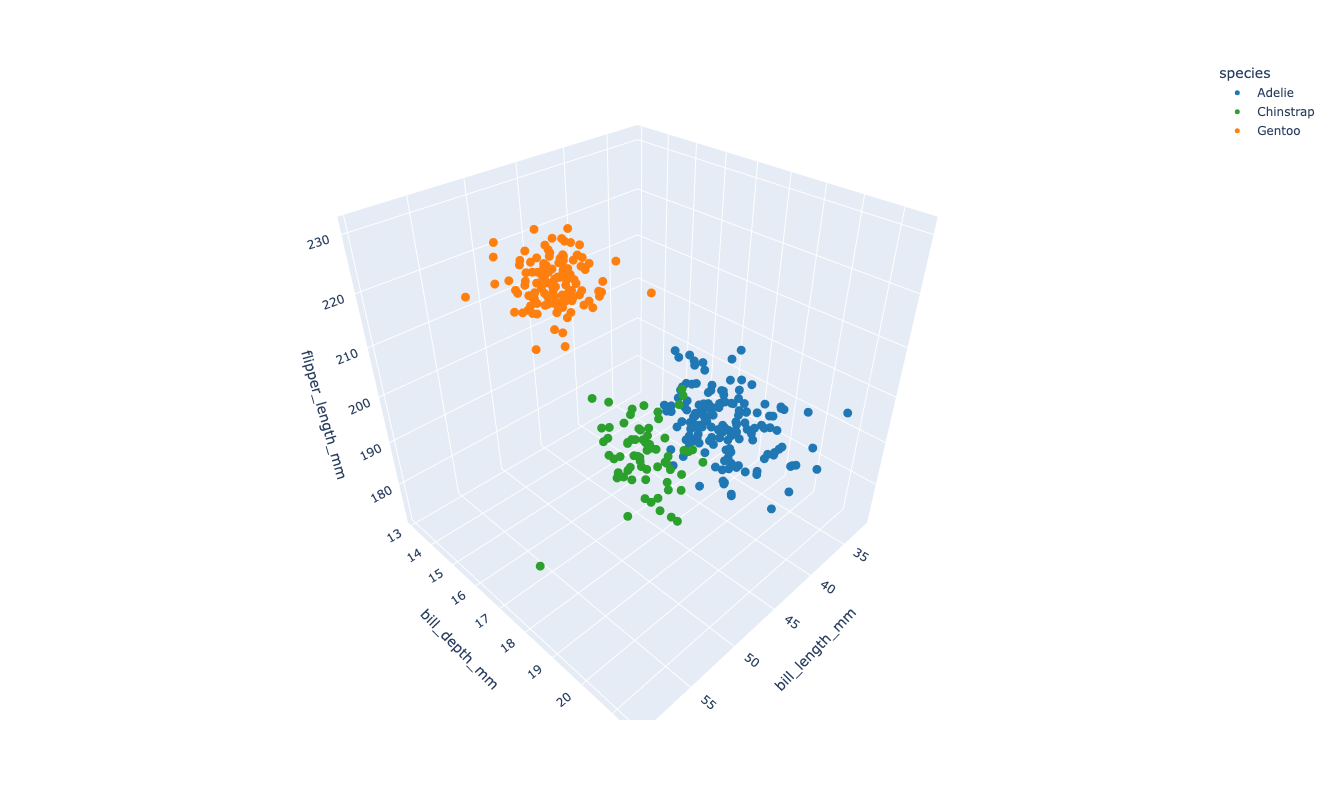

In [79]:
#vamos a utilizar la librería plotly para hacer el gráfico en 3D e interactivo
import plotly.express as px
SPECIES_COLORS = {
    "Adelie": "#1f77b4",
    "Gentoo": "#ff7f0e",
    "Chinstrap": "#2ca02c"
}
fig = px.scatter_3d(data_frame = data_k, x = 'bill_length_mm', y = 'bill_depth_mm', z = 'flipper_length_mm', color = 'species', height = 800, width = 800, color_discrete_map=SPECIES_COLORS)
fig.update_traces(marker=dict(size=5))  # ajustar tamaño de puntos 

Parecería ser que agregar una tercera dimensión separa bien nuestros puntos en dos grupos; la separación entre `Adelie` y `Chinstrap` es menos clara. Veamos qué sucede si aplicamos el algoritmo de k-means

In [81]:
X = data_k[['bill_depth_mm','bill_length_mm', 'flipper_length_mm']].to_numpy()
y = data_k.species.to_numpy()
kmeans= KMeans(n_clusters = 3, random_state = 42)

# Compute k-means clustering
kmeans.fit(X)

# Compute cluster centers and predict cluster index for each sample.
pred = kmeans.predict(X)

array([2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 0, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1,
       1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 1, 2,
       1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [82]:
data_k = data_k.assign(species_pred_2 = pred) # actualizamos la prediccion

/var/folders/zc/ty1kvmv55fs1z8sx922rqzsw0000gn/T/ipykernel_84251/3385095778.py:33: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



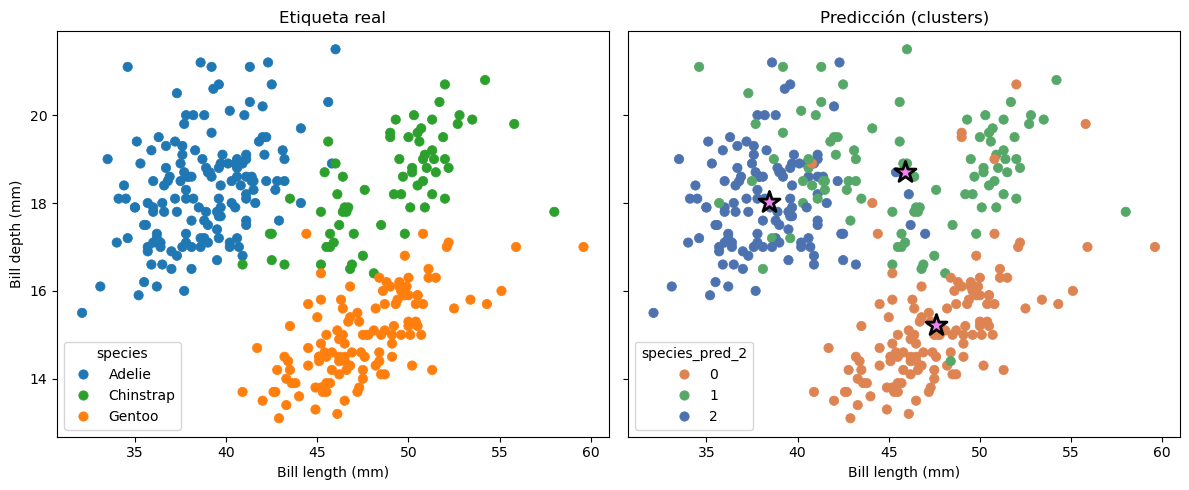

In [87]:
data_k['cluster'] = pd.Categorical(data_k['species_pred_2'], categories=list(CLUSTER_COLORS.keys()))

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

CLUSTER_COLORS = {0: COLORS[2], 
                  1: COLORS[1], 
                  2: COLORS[0]}

# Panel A: etiqueta real
sns.scatterplot(
    data=data_k, x='bill_length_mm', y='bill_depth_mm',
    hue='species', hue_order=species_order, palette=SPECIES_COLORS,
    s=45, edgecolor=None, ax=axes[0]
)
axes[0].set_title('Etiqueta real')
axes[0].set_xlabel('Bill length (mm)')
axes[0].set_ylabel('Bill depth (mm)')
axes[0].legend(title='species')

# Panel B: predicción (clusters)
cluster_order = list(CLUSTER_COLORS.keys())
sns.scatterplot(
    data=data_k, x='bill_length_mm', y='bill_depth_mm',
    hue='species_pred_2', hue_order=cluster_order, palette=CLUSTER_COLORS,
    s=45, edgecolor=None, ax=axes[1]
)
axes[1].set_title('Predicción (clusters)')
axes[1].set_xlabel('Bill length (mm)')
axes[1].set_ylabel('')

# Centroides (media por cluster en las dos variables ploteadas)
cent = (data_k
        .groupby('cluster')[['bill_length_mm', 'bill_depth_mm']]
        .mean()
        .reindex(cluster_order))

axes[1].scatter(
    cent['bill_length_mm'], cent['bill_depth_mm'],
    marker='*', s=250, linewidths=2, edgecolors='black',  
    c='violet', label='Centroides'
)

plt.tight_layout()
plt.show()

La cosa parece mejorar un poco. Veamos ahora el porcentaje de clasificación correcta...

In [88]:
cluster2species = {2:'Adelie', 0: 'Gentoo', 1: 'Chinstrap'}

In [89]:
data_k = data_k.assign(species_pred_2 = lambda df: [cluster2species.get(x) for x in df.cluster])

In [90]:
print(f'Porcentaje de clasificaciones correctas: {data_k.query("species == species_pred_2").shape[0]/data_k.shape[0]*100} %')

Porcentaje de clasificaciones correctas: 83.62573099415205 %


En efecto, aumetamos más de 20% los casos de acierto!

**Conclusión:** vemos que los datos tienen cierta estructuración respecto a las especies de pingüinos. Aplicando un algoritmo bastante sencillo, como lo es _k_-means clustering, pudimos _inferir_ grupos de puntos con características similares, los cuales sabemos por nuestra metadata corresponden a las especies. 

En nuestro curso exploraremos nociones sobre _embeddings_, donde el concepto de estructuración de los datos en un espacio multidimensional volverá a ser visto.

Cuantas más variables informativas consideramos, mejor fuimos en nuestra tarea. **La misma tarea se podría plantear como una regresión logística**, abordandola como un problema de aprendizaje supervisado. Volveremos sobre este punto en otros prácticos.

## Aprendizaje supervisado: prediciendo valores contínuos

Una aproximación distinta es la que llamamos **aprendizaje supervsisado**. Bajo esta lógica evaluaremos directamente el error que realizamos al llevar a cabo una tarea dada, e intentaremos minimizar dicho error iteración a iteración, con la esperanza de llegar a un modelo que realice pocos errores (y que generalice bien a otros datos!)

Una tarea clásica es intentar predecir un valor a partir de otro. Para arrancar podemos ver como correlacionan las variables en nuestro dataset

Correlacion:


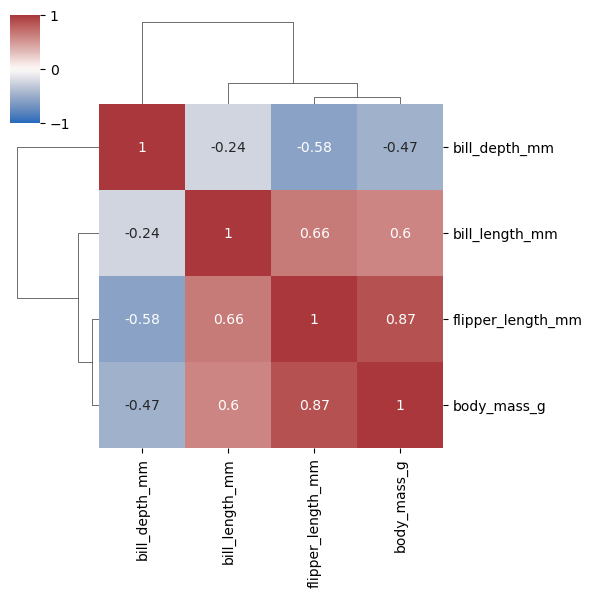

In [212]:
# calculamos la correlacion y agrupamos jerarquicamente usando el metodo .clustermap()
print('Correlacion:')
sns.clustermap(data.drop(['species', 'island','sex'], axis = 1).corr(),  
               figsize = (6,6), 
               cmap = 'vlag',
               vmax = 1, vmin = -1, annot = True)

Podemos ver que en la mayoría de los casos las variables correlacionan razonablemente entre si, ya sea en forma positiva o negativa.

___

**Pasemos ahora a intentar predecir, por ejemplo, el peso de un individuo a partir del largo de su aleta**, dado que estas dos variables parecen fuertemente correlacionadas. Para llevar a cabo esta tarea vamos a hacer una regresión lineal. 


Nos enfrentamos a un típico caso de ***aprendizaje supervisado***. Haremos una primer aproximación donde para una fracción de datos intentaremos hacer una predicción. Estimaremos el error en nuestro conjunto y en un conjunto de ***testeo***, que todavía no hayamos visto. Intentaremos luego modificar los pesos en nuestro modelo en una dirección donde el cambio sea favorable a realizar mejores predicciones; iteraremos el proceso durante varias ***épocas***.

Dejaremos parte de los datos para entrenar el algoritmo, y un conjunto aparte para ver qué tan bien generaliza nuestro modelo a datos que nunca vió (a estos subsets de datos se los llama _training_ y _validation_ set, respectivamente).


Antes que nada, veamos la relación entre las dos variables seleccionadas

<Axes: xlabel='flipper_length_mm', ylabel='body_mass_g'>

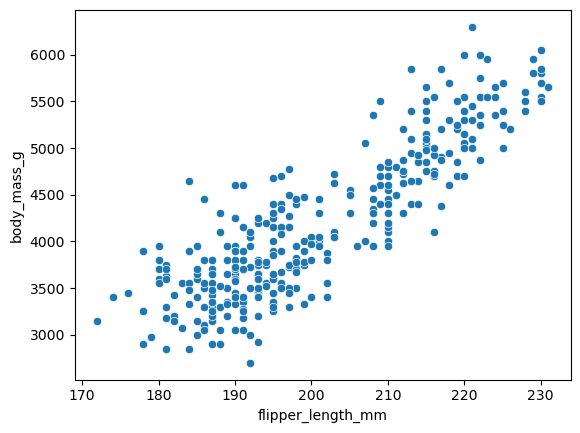

In [213]:
sns.scatterplot(data = data, x = 'flipper_length_mm', y = 'body_mass_g')

<Axes: xlabel='flipper_length_mm', ylabel='body_mass_g'>

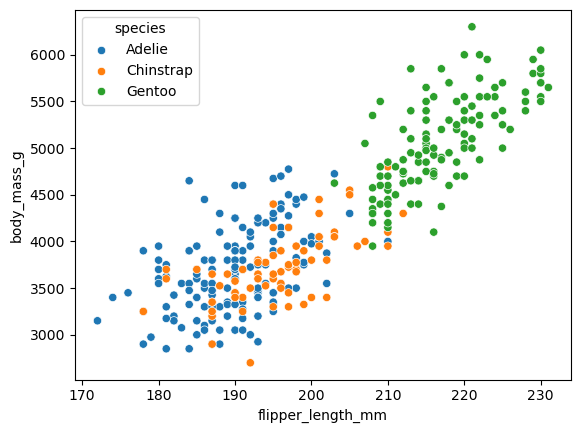

In [214]:
# vemos lo mismo segun especie?
sns.scatterplot(data = data, x = 'flipper_length_mm', y = 'body_mass_g', hue = 'species')

La relación entre ambas variables se ve bastante lineal. Podemos explorar aparte si otras variables... [**TODO**: completar]

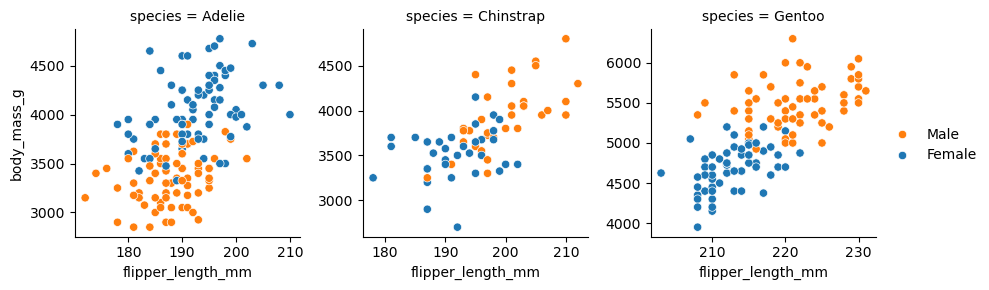

In [215]:
# y por sexo?
g = sns.FacetGrid(data, col="species", sharey = False, sharex = False)
g.map_dataframe(sns.scatterplot, x="flipper_length_mm", y="body_mass_g", hue="sex")
g.add_legend()

Ya nos divertimos un poco con los datos. Respecto a nuestra preocupación inicial (si la relación entre ambas variables podría ser estimada mediante una regresión lineal) parecería que podemos quedarnos tranquilos.

Seguramente ya te encontraste en varios cursos con regresiones lineales. La regresión lineal es un método que nos permite evaluar si entre dos variables existe una relación lineal y una vez determinada tal relación, predecir una de las variables a partír de la otra. Es decir, ajustaremos una recta a la relación entre nuestras dos variables medidas. Para eso, suponemos que nuestra variable dependiente (y) cambia en función de nuestra variable independiente (x) según la siguiente expresión:

$$y = ax + b$$

Tengamos en cuenta que entonces que, si tenemos $n$ pares de observaciones $(x_i,y_i)$, podemos expresar esto con notación matricial como

$$\begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix} = a \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \end{bmatrix} + b$$

o, lo que es más sencillo

$$ \mathbf{\hat{y}} = a\mathbf{x} + b$$

donde simplemente hicimos un cambio de notación.

Debemos encontrar, entonces, los parámetros $a$ y $b$ que mejor se ajustan a nuestro _set_ de datos. Luego, a partir de estos parámetros podremos predecir valores de $y$ para valores de $x$ no medidos.


Para estimar estos parámetros emplearemos un método llamado 'mínimos cuadrados', que busca minimizar el error entre cada observación y el valor predicho por nuestra ecuación de la recta.

Podemos definir el error para un determinado dato $x_i$ como $$r_i = y_i - (ax_i + b)$$

Es decir, la diferencia entre el valor observado $y_i$ y el que estimamos $ax_i+b$.
Luego, para estimar los valores de $a$ y $b$, la estrategia es minimizar el error total de nuestra regresión, o sea la suma de todos los errores individuales $r_i$. De forma que nuestro error total ($e$) valdrá:

$$e = Σ^N_{i=1}r_i^2=Σ^N_{i=1}(y_i-(ax_i +b))^2$$


Queremos ahora hallar los valores de $a$ y $b$ que minimizan este error total. 


Una forma para hacer esto es tomar una ***aproximación analítica*** (i.e., buscando la solución exacta con ecuaciones). Hallamos las derivadas parciales de $e$ respecto de $a$ y de $b$, y las evaluamos en 0 (buscando así los valores que maximizan). De esta forma se ob†iene:

$$a={Σ^N_{i=1} (x_i - x̄)(y_i - \overline{y}) \over \Sigma (x_i - \overline{x})^2}$$

y

$$b = \overline{y} - a * \overline{x}$$

Implementemos nuestra solución entonces para estimar la masa en gramos de un pingüino en base a el largo de su aleta

In [95]:
import numpy as np

In [96]:
data_r = data.query("not flipper_length_mm.isnull() and not body_mass_g.isnull()", engine = 'python')

In [97]:
# guardamos ambos valores
largo_aletas = data_r.flipper_length_mm.to_numpy() * 0.1 # lo llevamos a un array de numpy con datos en cm
masa_pinguinos = data_r.body_mass_g.to_numpy() * 1e-3 # llevamos a kg

# sacamos los promedios para estos valores
largo_promedio_aleta = np.mean(largo_aletas)
masa_promedio_pinguinos = np.mean(masa_pinguinos)

**Adaptar esto**

> Chapter 6 introduced iterative optimization algorithms. These are general-purpose meth-
ods for finding the minimum of a function. In the context of neural networks, they find
parameters that minimize the loss so that the model accurately predicts the training
outputs from the inputs. The basic approach is to choose initial parameters randomly
and then make a series of small changes that decrease the loss on average. Each change is
based on the gradient of the loss with respect to the parameters at the current position.

In [98]:
# Primero inicializamos el numerador y denominador para el parámetro a, que luego modificaremos en un loop for
numerador = 0 ;
denominador = 0 ;

for i in range(len(largo_aletas)):
  numerador += (largo_aletas[i]-largo_promedio_aleta)*(masa_pinguinos[i]-masa_promedio_pinguinos)
  denominador += (largo_aletas[i]-largo_promedio_aleta)**2 # El operador ** es el 'elevado a' de Python

a = numerador / denominador
b = masa_promedio_pinguinos - a * largo_promedio_aleta

print(a,b)

0.4968556640610008 -5.780831358077062


Notamos que, como habíamos visto, a mayor largo de aleta, mayor es la masa de los pingüinos (esto se deduce de $a > 0$). Particularmente, podemos describir la masa de los pingüinos ($y$) como una función del largo de aleta ($x$) de la siguiente manera:
$$ y = 0.49 x - 5.78 $$

Grafiquemos esta relación junto con nuestros datos para observarlo mejor.

In [100]:
a

0.4968556640610008

In [101]:
b

-5.780831358077062

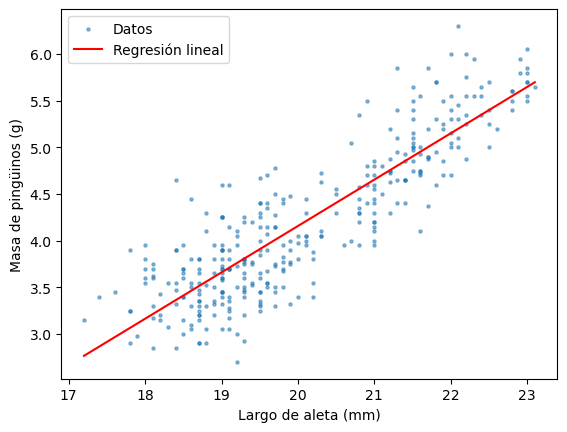

In [102]:
x = np.linspace(np.min(largo_aletas), np.max(largo_aletas), 1000)
y = a*x + b

fig, ax = plt.subplots()
#Graficamos nuestos puntos
ax.scatter(largo_aletas, masa_pinguinos, alpha=0.5,s=5, label='Datos') #seteamos la opacidad (alpha) y el tamaño (s) de los puntos ya que muchos se solapan y de esta forma podemos distinguirlos mejor
#Graficamos la regresión lineal
plt.plot(x,y,color='red', label='Regresión lineal')
#Seteamos los nombres de los ejes
ax.set_xlabel('Largo de aleta (mm)')
ax.set_ylabel('Masa de pingüinos (g)')
#Le decimos que muestre la leyenda y por último que grafique
ax.legend()
plt.show()


Si bien a simple vista parece ajustarse bastante bien, debemos definir una forma cuantitativa para evaluar qué tan bien se ajusta nuestro modelo. Usaremos dos: el error cuadrático medio (RMSE) y el coeficiente de determinación ($R^2$)

El RMSE es la raiz del promedio de los cuadrados de todos los errores. Matemáticamente: $$ RMSE = \sqrt {{1 \over N}Σ^N_{i=1}(y_i-y^p_i)^2}$$ Donde $y^p_i$ es el y predicho por nuestra regresión para ese valor.

In [103]:
#Calculemos el RMSE
suma_cuadrados = 0
N = len(largo_aletas)

for i in range(N):
  y_pred = a*largo_aletas[i] + b
  suma_cuadrados += (largo_aletas[i]-y_pred)**2

RMSE = np.sqrt(suma_cuadrados/N)

print('RMSE: ' + str(RMSE))

RMSE: 15.905463491279711


Ahora, el coeficiente de determinación $R^2$ es la porción de la varianza total que se explica por nuestra regresión. Matemáticamente:
$$R^2 = {\Sigma^N_{i=1} (y^p_i -\overline{y})^2 \over \Sigma^N_{i=1}(y_i - \overline{y})^2}$$

In [104]:
#Calculemos R^2
numerador = 0
denominador = 0

for i in range(N):
  y_pred = a*largo_aletas[i] + b
  numerador += (y_pred-masa_promedio_pinguinos)**2
  denominador += (masa_pinguinos[i]-masa_promedio_pinguinos)**2

R2 = (numerador/denominador)
print('R^2: ' + str(R2))

R^2: 0.7589925193571173


Lo cual es una correlación bastante buena teniendo en cuenta que estos son datos biológicos reales!

___

Muy bien, ahora tomemos una segunda aproximación a este problema de determinar (o, en este caso, podríamos decir ***aprender***) qué valores de $a$ y $b$ ajustarían mejor a nuestros datos.

Imaginemos que no tuvieramos una solución analítica a este problema: en la vida real esto pasa en muchas situaciones, ya sea porque las ecuaciones que describen razonablemente la realidad no tienen soluciones exactas, o porque directamente no tenemos una ecuación realista que sepa capturar la relación en nuestros datos.

**Podemos resolver el problema de alguna forma?** Si la respuesta fuese no, el notebook no seguiría y el curso sería bastante corto 🙂.  

Recordemos que nuestra solución **minimiza el error** para nuestro set de datos. Entonces, lo que podemos hacer es calcular el error e intentar disminuirlo iteración a iteración modificando los valores de $a$ y $b$. Podemos, por ejemplo, variar $a$ hasta encontrar que ni aumentarlo ni disminuirlo mejoran nuestro error, y luego pasar a hacer lo mismo con $b$.

Veamos si esto funciona

## Buscando minimizar la función de pérdida

> La función que puede usarse fácil en las diapos para explicar gradient descent es f(x)=2x²-2, que tiene mínimo en  0. La derivada es f'(x)=4x y por lo tanto dx=x{t-1}-4ex{t-1} , o sea xt=x0(1-4e)^t que converge si e<1/4

> The loss depends on the network parameters, and this chapter considers how to find
the parameter values that minimize this loss. This is known as learning the network’s
parameters or simply as training or fitting the model. The process is to choose initial
parameter values and then iterate the following two steps: (i) compute the derivatives
(gradients) of the loss with respect to the parameters, and (ii) adjust the parameters
based on the gradients to decrease the loss. After many iterations, we hope to reach the
overall minimum of the loss function.

$$\hat{\phi} = \text{argmin}_\phi^{} \ L[\phi]$$

El más simple de estos métodos se llama _descenso por gradiente_. Si tenemos $N$ parámetros, donde $\phi = [\phi_1, \phi_2, \dots, \phi_N]^T$, el descenso por gradiente se compone esencialmente de dos pasos

1. **Computar el gradiente de la función de pérdida respecto a los parámetros**, es decir

$$\frac{\partial L}{\partial \phi} = \begin{bmatrix} \frac{\partial L}{\partial \phi_1} \\ \frac{\partial L}{\partial \phi_2} \\ \vdots \\ \frac{\partial L}{\partial \phi_N} \end{bmatrix}$$

2. **Actualizar los parámetros**. Esto se hace teniendo en cuenta el gradiente y un factor de escalado $\alpha$ (generalmente llamado _learning rate_), siguiendo

$$\phi_{i+1} \leftarrow \phi_i - \alpha \cdot \frac{\partial L}{\partial \phi}$$

en donde cada parámetro $\phi_i$ se actualiza según el correspondiente valor $-\alpha \cdot \frac{\partial L}{\partial \phi_i}$ (es decir, cuánto su cambio infinitesimal modifica a la función de pérdida, multiplicado por el _learning rate_ $\alpha$). El signo de menos nos asegura el ir en contra del gradiente (i.e., buscar el descenso de la función de pérdida).

___

Refresquemos estos conceptos con un caso bien sencillo. Consideremos que tenemos una función de pérdida cuya dependencia respecto a los parámetros está descrita por $L [\phi] = 2\phi^2 -2$, donde el único parámetro en el modelo es $\phi$. 

En un momento dado, el parámetro es $\phi_0 = -3$, lo cual implica que el _loss_ es de $L[\phi] = 16$.


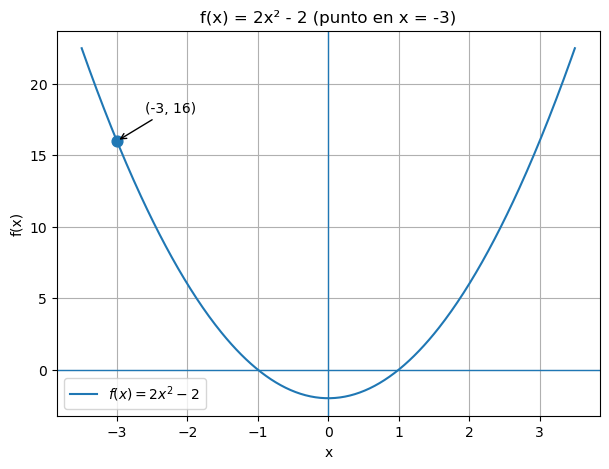

In [105]:
# Gráfico de f(x) = 2x^2 - 2 con un punto marcado en x = -3
import numpy as np
import matplotlib.pyplot as plt

# Dominio y función
x = np.linspace(-3.5, 3.5, 400)
f = 2*x**2 - 2

plt.figure(figsize=(7, 5))
plt.plot(x, f, label=r"$f(x)=2x^2-2$")
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)

# Punto en x = -3
x0 = -3
y0 = 2*(x0**2) - 2  # 16
plt.scatter([x0], [y0], s=60, zorder=3)
plt.annotate(f"(-3, {y0:.0f})", xy=(x0, y0), xytext=(-2.6, y0+2),
             arrowprops=dict(arrowstyle="->"))

plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("f(x) = 2x² - 2 (punto en x = -3)")
plt.grid(True)
plt.legend()
plt.show()


¿Cómo funcionaría el gradiente por descenso en este caso, si tomamos un _learning rate_ $\alpha = 0.05$. Hagamos un _for loop_ para verlo. Pediremos al algoritmo que se detenga cuando el cambio de _loss_ $\Delta L$ sea arbitrariamente chico (digamos, $1e-12$. Recordemos que en este caso tenemos

$$L [\phi] = 2\phi^2 -2 \rightarrow \frac{\partial L}{\partial \phi} = 4 \phi$$

lo cual emplearemos en nuestra implementación del algoritmo

In [107]:
from matplotlib import cm
from matplotlib.colors import Normalize

In [108]:
# Parámetros
tolerancia = 1e-12
phi = -3.0               # x inicial
alpha = 0.05             # tasa de aprendizaje
max_iter = 10_000

# Función y gradiente
f = lambda x: 2*x**2 - 2
df = lambda x: 4*x

# vamos a ir guardando los valores
phis = [phi]
Ls = [f(phi)] # el primer loss es aplicar f al punto inicial, phi
deltas = [np.nan]  # delta L para la iteracion tiene que ser inexistente

# Loop de descenso por gradiente
L_prev = Ls[-1]
i = 1
while i <= max_iter: # vamos solo
    g = df(phi) # calulamos el gradiente
    phi = phi - alpha * g # actualizamos phi con gradiente y learning rate
    L_new = f(phi) # calculamos el loss correspondiente
    diff_L = abs(L_prev - L_new) # calculamos diferencia de loss
    
    phis.append(phi) # actualizamos listas
    Ls.append(L_new)
    deltas.append(diff_L)
    
    if diff_L <= tolerancia: # si la diferencia es muy chica, paramos
        break
    L_prev = L_new # actualizamos L_prev
    i += 1 # 

# Tabla con el historial de iteraciones
hist = pd.DataFrame({
    "iter": range(len(phis)),
    "x": phis,
    "L": Ls,
    "delta_L": deltas
})

In [110]:
hist

,iter,x,L,delta_L
0,0,-3.000000e+00,16.000000,NaN
1,1,-2.400000e+00,9.520000,6.480000e+00
2,2,-1.920000e+00,5.372800,4.147200e+00
3,3,-1.536000e+00,2.718592,2.654208e+00
4,4,-1.228800e+00,1.019899,1.698693e+00
...,...,...,...,...
64,64,-1.883131e-06,-2.000000,3.989475e-12
65,65,-1.506504e-06,-2.000000,2.553291e-12
66,66,-1.205204e-06,-2.000000,1.634026e-12
67,67,-9.641628e-07,-2.000000,1.045830e-12


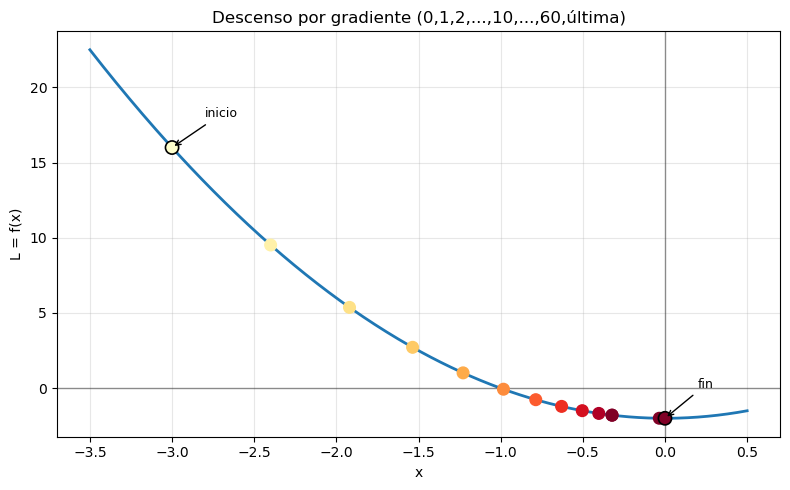

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Indices: 0, 10, ..., 60 y última
last = len(phis) - 1
idx_keep = list(range(0, min(60, last) + 1, 10))
idx_keep = idx_keep = idx_keep + list(range(0,11))
if last not in idx_keep:
    idx_keep.append(last)
idx_keep = sorted(idx_keep)

phis_sub = [phis[i] for i in idx_keep]
Ls_sub   = [Ls[i]   for i in idx_keep]

# Curva de f(x)
x_grid = np.linspace(min(phis) - 0.5, max(phis) + 0.5, 400)
y_grid = f(x_grid)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x_grid, y_grid, linewidth=2, label=r"$f(x)=2x^2-2$")
ax.axhline(0, linewidth=1, color='k', alpha=0.4)
ax.axvline(0, linewidth=1, color='k', alpha=0.4)

# Colores amarillo → rojo mapeados a la iteración real
iters_sub = np.array(idx_keep)
cmap = plt.colormaps['YlOrRd']
norm = mcolors.Normalize(vmin=0, vmax=10)

sc = ax.scatter(phis_sub, Ls_sub, c=iters_sub, cmap=cmap, norm=norm,
                s=70, zorder=3, label="Iteraciones seleccionadas")

# Marcas de inicio y fin
ax.scatter([phis_sub[0]], [Ls_sub[0]], s=90, edgecolor="k", facecolor="none", linewidth=1.2, zorder=4)
ax.annotate("inicio", xy=(phis_sub[0], Ls_sub[0]),
            xytext=(phis_sub[0] + 0.2, Ls_sub[0] + 2),
            arrowprops=dict(arrowstyle="->"), fontsize=9)

ax.scatter([phis[-1]], [Ls[-1]], s=90, edgecolor="k", facecolor="none", linewidth=1.2, zorder=4)
ax.annotate("fin", xy=(phis[-1], Ls[-1]),
            xytext=(phis[-1] + 0.2, Ls[-1] + 2),
            arrowprops=dict(arrowstyle="->"), fontsize=9)

ax.set_xlabel("x")
ax.set_ylabel("L = f(x)")
ax.set_title("Descenso por gradiente (0,1,2,...,10,...,60,última)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Como podemos apreciar, iteración a iteración el valor de loss va descendiendo, siguiendo el gradiente calculado a la tasa de aprendizaje determinada.

___

Ahora que vimos en acción la lógica del descenso de gradiente, **volvamos a nuestra regresión lineal**. En nuestro caso tenemos que hacer descenso por gradiente **para dos variables**, $a$ y $b$. 

Haciendo algunas cuentas podemos sacar el gradiente del _loss_ en este caso, que era $RMSE$

$$\text{RMSE} = \sqrt{\frac{1}{N}\sum_{i=1}^N (y_i - y_i^p)^2}$$

donde teníamos que cada predicción era $y_i^p = ax_i + b$ (el valor de la regresión lineal.

Para simplificarnos la vida hacemos un cambio de notación, englobando el error en $e_i = y_i - y_i^p = y_i - (ax_i+b)$.
Si hacemos esto nos queda

$$\text{RMSE} = \sqrt{\frac{1}{N}\sum_{i=1}^N e_i^2}$$

Te invitamos a que intentes calcular los gradientes respectivos ($\frac{\partial \text{RMSE}}{\partial a}$ y $\frac{\partial \text{RMSE}}{\partial b}$). Si se te complica, podes apretar el botón a continuación para ver una solución


<details>
<summary>Derivadas parciales de RMSE</summary>
Calcular estos gradientes implica calcular derivadas de una función cuadrática. Recordemos que

$$
f(x) = \sqrt{x} \;\Rightarrow\; \frac{\partial f(x)}{\partial x} = \frac{1}{2 \sqrt{x}}
$$

Un cambio de notación nos va a ayudar. Definamos

$$
\mathrm{MSE} = \frac{1}{N}\sum_{i=1}^N e_i^2
$$

y así pasamos a tener

$$
\mathrm{RMSE} = \sqrt{\mathrm{MSE}}
$$

Por la regla de la cadena esto nos va a permitir calcular las derivadas de $\mathrm{RMSE}$. Por ejemplo

$$
\frac{\partial \,\mathrm{RMSE}}{\partial a} = \frac{1}{2\sqrt{\mathrm{MSE}}} \cdot \frac{\partial \mathrm{MSE}}{\partial a}
$$

Así que ahora nuestro problema se reduce a calcular, para valores $\theta = a$ o $\theta = b$,

$$
\mathrm{MSE} = \frac{1}{N}\sum_{i=1}^N e_i^2, \qquad
\frac{\partial \mathrm{MSE}}{\partial \theta} = \frac{2}{N}\sum_{i=1}^N e_i \frac{\partial e_i}{\partial \theta}.
$$

$$
e_i = y_i - (a x_i + b)
\quad \Rightarrow \quad
\frac{\partial e_i}{\partial a} = -x_i
$$

Por lo tanto,

$$
\frac{\partial \mathrm{MSE}}{\partial a} = \frac{2}{N}\sum_{i=1}^N e_i (-x_i) = -\frac{2}{N}\sum_{i=1}^N e_i x_i
$$

y

$$
\frac{\partial \,\mathrm{RMSE}}{\partial a} = \frac{1}{2\sqrt{\mathrm{MSE}}} \cdot \Big(-\frac{2}{N}\sum_{i=1}^N e_i x_i\Big)
= -\frac{1}{N\,\mathrm{RMSE}} \sum_{i=1}^N e_i x_i.
$$

Análogamente, como $\frac{\partial e_i}{\partial b} = -1$,

$$
\frac{\partial \mathrm{MSE}}{\partial b} = \frac{2}{N}\sum_{i=1}^N e_i(-1) = -\frac{2}{N}\sum_{i=1}^N e_i,
$$

entonces

$$
\frac{\partial \,\mathrm{RMSE}}{\partial b} = \frac{1}{2\sqrt{\mathrm{MSE}}} \cdot \Big(-\frac{2}{N}\sum_{i=1}^N e_i\Big)
= -\frac{1}{N\,\mathrm{RMSE}} \sum_{i=1}^N e_i.
$$

con lo cual tenemos

$$
\boxed{ \frac{\partial \,\mathrm{RMSE}}{\partial a} = -\frac{1}{N \cdot \mathrm{RMSE}} \sum_{i=1}^N (y_i - (a x_i + b))\,x_i }
$$

$$
\boxed{ \frac{\partial \,\mathrm{RMSE}}{\partial b} = -\frac{1}{N \cdot \mathrm{RMSE}} \sum_{i=1}^N (y_i - (a x_i + b)) }
$$
</details>

Después de esta refrescante gimnasia matemática podemos pasar a implementar el descenso por gradiente en nuestro caso

In [223]:
N = len(largo_aletas)
lr = 0.001           # arrancá con 0.1; si diverge, bajá a 0.05/0.01
max_iter = 3000_000
tol = 1e-9
eps = 1e-12         # para evitar división por cero cuando RMSE ~ 0

# Parámetros (a: pendiente, b: intercepto)
a = 0
b = 0

rmse_hist = [] # para ir guardando valores

As = []
Bs = []

for t in range(max_iter):
    y_pred = a * largo_aletas + b # calculamos valores predichos
    residual = masa_pinguinos - y_pred # calculamos diferencia entre valores predichos y valores reales
    mse = np.mean(residual ** 2)
    rmse = np.sqrt(mse + eps)  # eps evita problemas si mse→0
    rmse_hist.append(rmse)

    # gradientes de rmse
    grad_a = -(1.0 / (N * rmse)) * np.sum(residual * largo_aletas)
    grad_b = -(1.0 / (N * rmse)) * np.sum(residual)

    As.append(a)
    Bs.append(b)
    
    # Update
    a_new = a - lr * grad_a # hacemos la actualizacion
    b_new = b - lr * grad_b
    
    # si en algun caso ya el cambio no hace nada, paramos
    if np.abs(a_new - a) < tol and np.abs(b_new - b) < tol:
        a, b = a_new, b_new
        break

    a, b = a_new, b_new # actualizamos a y b para seguir

print(f"a (pendiente): {a.item():.6f}")
print(f"b (intercepto): {b.item():.6f}")
print(f"Iteraciones: {len(rmse_hist)}")

a (pendiente): 0.496852
b (intercepto): -5.780750
Iteraciones: 925458


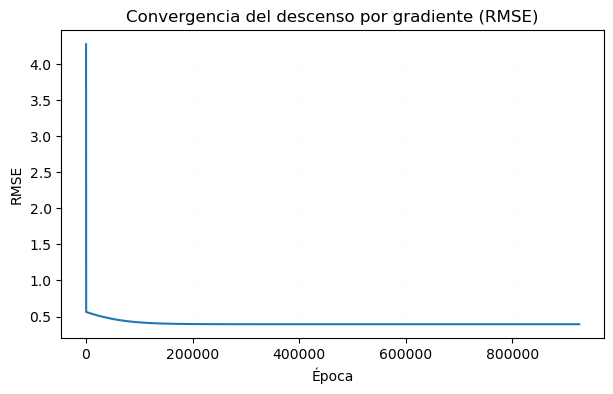

In [225]:
plt.figure(figsize=(7,4))
plt.plot(rmse_hist)
plt.xlabel("Época")
plt.ylabel("RMSE")
plt.title("Convergencia del descenso por gradiente (RMSE)")
plt.grid(True, alpha=0.03)
plt.show()

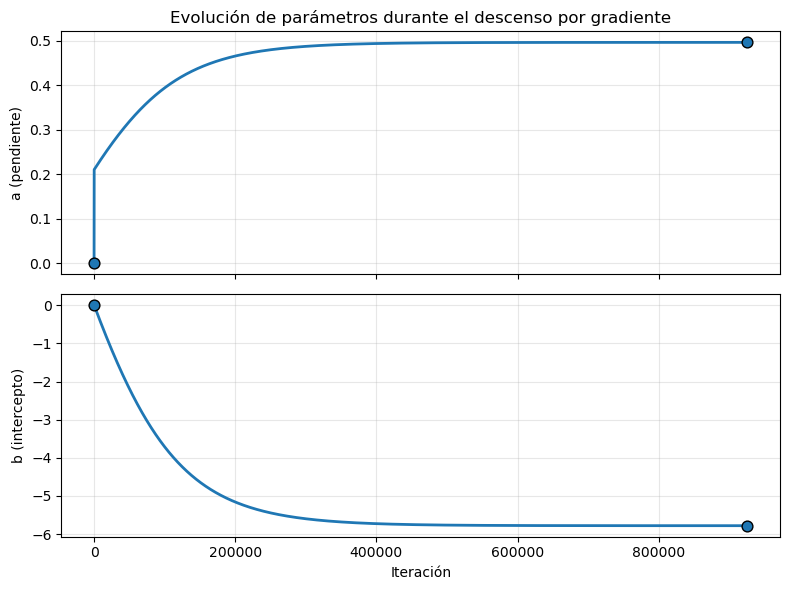

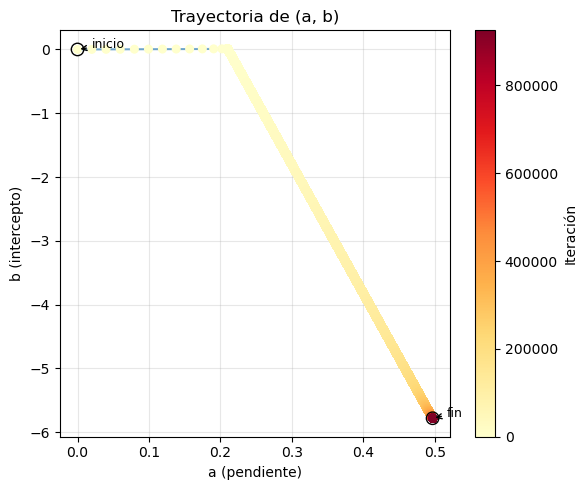

In [226]:
# Asegurar arrays
As_arr = np.asarray(As, dtype=float)
Bs_arr = np.asarray(Bs, dtype=float)
t = np.arange(len(As_arr))

# ===== 1) a(t) y b(t) =====
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axes[0].plot(t, As_arr, lw=2)
axes[0].scatter([t[0], t[-1]], [As_arr[0], As_arr[-1]], s=60, edgecolor='k', zorder=3)
axes[0].set_ylabel("a (pendiente)")
axes[0].grid(True, alpha=0.3)
axes[0].set_title("Evolución de parámetros durante el descenso por gradiente")

axes[1].plot(t, Bs_arr, lw=2)
axes[1].scatter([t[0], t[-1]], [Bs_arr[0], Bs_arr[-1]], s=60, edgecolor='k', zorder=3)
axes[1].set_xlabel("Iteración")
axes[1].set_ylabel("b (intercepto)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ===== 2) Trayectoria en el espacio (a, b) con color por iteración =====
fig, ax = plt.subplots(figsize=(6, 5))
cmap = plt.colormaps['YlOrRd']
norm = mcolors.Normalize(vmin=t.min(), vmax=t.max())

# puntos coloreados + línea que los une
sc = ax.scatter(As_arr, Bs_arr, c=t, cmap=cmap, norm=norm, s=30, zorder=3, label="iteraciones")
ax.plot(As_arr, Bs_arr, lw=1.5, alpha=0.6)

# inicio/fin
ax.scatter([As_arr[0]], [Bs_arr[0]], s=80, edgecolor='k', facecolor='none', zorder=4)
ax.annotate("inicio", xy=(As_arr[0], Bs_arr[0]), xytext=(As_arr[0]+0.02, Bs_arr[0]+0.02),
            arrowprops=dict(arrowstyle="->"), fontsize=9)
ax.scatter([As_arr[-1]], [Bs_arr[-1]], s=80, edgecolor='k', facecolor='none', zorder=4)
ax.annotate("fin", xy=(As_arr[-1], Bs_arr[-1]), xytext=(As_arr[-1]+0.02, Bs_arr[-1]+0.02),
            arrowprops=dict(arrowstyle="->"), fontsize=9)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Iteración")

ax.set_xlabel("a (pendiente)")
ax.set_ylabel("b (intercepto)")
ax.set_title("Trayectoria de (a, b)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**En conclusión**, podemos ver que el descenso por gradiente funcionó para encontrar los parámetros de $a$ y $b$ que minimizan mínimos cuadrados a los puntos.

Llegado este punto sería normal que te surjan algunas inquietudes: **¿vamos a tener que calcular las derivadas parciales de todas las funciones de pérdida que vayamos a usar respecto a todos los parámetros e implementarlos a mano?**.

La respuesta corta es: no. Existen varias librerías que implementan el descenso por gradiente y otros algoritmos por nosotros (ahorrandonos toda esta parte).

### Implementación en PyTorch

*Tiempo estimado: ~x horas*
___


Como ya dijimos, el objetivo de este práctico es también familiarizarnos con herramientas básicas de PyTorch, una librería para armar y entrenar modelos de aprendizaje profundo con la que vamos a trabajar el resto del curso. 

Teniendo en cuenta esto, naturalmente lo que nos interesa es aproximarnos a la regresión lineal desde la perspectiva de una red neuronal.

Como un primer paso, vamos a ver cómo sería nuestro loop de entrenamiento usando funciones de esta librería

![](https://media.geeksforgeeks.org/wp-content/uploads/20250908175337767153/training_neural_networks_with_pytorch.webp)

In [254]:
import random, math
import numpy as np
import torch

In [ ]:
# ==== datos desde nuestros arrays numpy a tensores de pytorch ====
# largo_aletas (cm), masa_pinguinos (kg)
x = torch.from_numpy(largo_aletas.astype(np.float64))    # generamos un tensor con los valores de largo de aleta
y = torch.from_numpy(masa_pinguinos.astype(np.float64))  # generamos un tensor con los valores de masa de los pinguinos

In [ ]:
# ==== split de datos 70/30 con libreria 'random' ====
N = x.shape[0]
idx = list(range(N))
random.seed(42) # semilla para reproducibilidad
random.shuffle(idx)  
n_tr = int(0.7 * N)
idx_tr = torch.tensor(idx[:n_tr], dtype=torch.long)
idx_te = torch.tensor(idx[n_tr:],  dtype=torch.long)

xtr, ytr = x[idx_tr], y[idx_tr]
xte, yte = x[idx_te], y[idx_te]

In [271]:
# ==== seteo de iperparámetros ====
lr = 1e-3
max_iter = 300_000
tol = 1e-9
eps = 1e-12

# ==== parámetros (a, b) con gradiente ====
a = torch.tensor(0.0, dtype=torch.float64, requires_grad=True) # el requires_grad=True es necesario para luego poder colectar los gradientes
b = torch.tensor(0.0, dtype=torch.float64, requires_grad=True) # idem

# ==== definicion del loss ====
mse_loss = torch.nn.MSELoss() # vamos a usar MSE en vez de RMSE porque ya tiene una implementacion en PyTorch

rmse_hist, As, Bs = [], [], [] # listas para guardar valores

In [272]:
# loop de entrenamiento
for t in range(max_iter):
    # forward pass (trainining)
    y_estimado = a * xtr + b
    mse = mse_loss(y_estimado, ytr)              # <- loss 
    rmse = torch.sqrt(mse + eps).item()    # <- métrica (solo para log)

    # logging
    rmse_hist.append(rmse)
    As.append(a.item()); Bs.append(b.item())

    # backward
    mse.backward() # llamando a .backward(), autograd (otra funcion) calcula el gradiente de loss con respecto a las variables
                   # y las aloja en <variable>.grad 

    # vamos a colectar cada paso, multiplicando gradientes por learning rate
    step_a = lr * a.grad.item() # en esta parte estamos recuperando el gradiente del loss respecto a _a_
    step_b = lr * b.grad.item() # idem, gradiente de loss respecto a _b_

    # actualizacion manual 
    with torch.no_grad():
        a -= step_a # actualizamos nuestras variables
        b -= step_b
        a.grad.zero_(); b.grad.zero_() # llevamos los gradientes a cero

    if (abs(step_a) < tol) and (abs(step_b) < tol): # si las dos variables se mueven muy poco paramos
        break

print(f"a (pendiente):  {a.item():.6f}")
print(f"b (intercepto): {b.item():.6f}")
print(f"Iteraciones:    {len(rmse_hist)}")

a (pendiente):  0.472346
b (intercepto): -5.269489
Iteraciones:    300000


In [273]:
# ==== Métricas finales en train/test ====
def metrics(x_, y_, a_, b_):
    with torch.no_grad():
        yhat_ = a_ * x_ + b_
        mse_  = torch.mean((y_ - yhat_)**2).item()
        rmse_ = math.sqrt(mse_)
        mae_  = torch.mean(torch.abs(y_ - yhat_)).item()
        r2_   = (1 - torch.sum((y_ - yhat_)**2) / torch.sum((y_ - y_.mean())**2)).item()
    return rmse_, mae_, r2_

rmse_tr, mae_tr, r2_tr = metrics(xtr, ytr, a, b)
rmse_te, mae_te, r2_te = metrics(xte, yte, a, b)

print(f"[TRAIN] RMSE={rmse_tr:.4f} kg | MAE={mae_tr:.4f} kg | R²={r2_tr:.4f}")
print(f"[TEST ] RMSE={rmse_te:.4f} kg | MAE={mae_te:.4f} kg | R²={r2_te:.4f}")

[TRAIN] RMSE=0.3766 kg | MAE=0.3054 kg | R²=0.7703
[TEST ] RMSE=0.4350 kg | MAE=0.3427 kg | R²=0.7278


> Por qué _test_ y _train_ no dan lo mismo? Para pensar...

Si te acordás, teníamos

$$ \mathbf{\hat{y}} = a\mathbf{x} + b$$

una expresión para

$$\begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix} = a \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \end{bmatrix} + b$$

Aquí estamos aplicando un peso a cada uno de nuestros datos, sumandole un término de desvío (o _bias_).

En las clases que vienen vamos a ver que esto equivale a lo que le llamamos una _neurona_ con dos parámetros. De hecho en PyTorch ya está implementada como una función llamada `Linear` dentro del módulo `torch.nn`. Este modulo tiene varias arquitecturas que iremos descubriendo en el curso.

También existen otros algoritmos para hacer descenso de gradiente. En PyTorch se encuentran en el módulo `torch.optim`, y también los exploraremos a lo largo del curso.

# Ejercicio